In [1]:
from utils import *

In [2]:
components0, components1 = generate_remapping_components(use_distorted_jar=False)

# Create a scene where the indices of refraction of refractive elements are slightly different
diff_iors={
    'sapphire_ior': 1.77*0.99,
    'quartz_ior': 1.458*0.99,
    'CF4_ior': 1.22*0.99,
    'Ar_ior': 1.17*0.99,
    'vacuum_ior': 1.0,
}
materials_diff_iors = create_materials(with_fluids=True, iors=diff_iors)
components2 = load_components(materials_diff_iors)

# Optional use: distorted jar surfaces
materials = create_materials(with_fluids=True)
components3 = load_components(materials=materials, use_distorted_jar=True)

spp=16
c1 = create_sensor(sensor_number=1, sample_count=spp)
c2 = create_sensor(sensor_number=2, sample_count=spp)
c3 = create_sensor(sensor_number=3, sample_count=spp)

# Extract projection matrices from sensors
c1pose = np.array(c1['to_world'].matrix)[:3,:]
c2pose = np.array(c2['to_world'].matrix)[:3,:]
c3pose = np.array(c3['to_world'].matrix)[:3,:]

# Optionally use estimated pose matrices
estimated_poses_loc = "outputs/estimated_pose_matrices/"
c1pose = np.load(estimated_poses_loc+"c1posep.npy")
c2pose = np.load(estimated_poses_loc+"c2posep.npy")
c3pose = np.load(estimated_poses_loc+"c3posep.npy")

poses = np.stack([c1pose, c2pose, c3pose], axis=0)
print(poses)

2024-08-14 18:01:40 WARN main [PLYMesh] "outer_jar_outer_surface_top_distorted.ply": skipping unknown element "edge"

2024-08-14 18:01:40 WARN main [PLYMesh] "outer_jar_inner_surface_top_distorted.ply": skipping unknown element "edge"

2024-08-14 18:01:40 WARN main [PLYMesh] "inner_jar_outer_surface_bottom.ply": skipping unknown element "edge"

2024-08-14 18:01:40 WARN main [PLYMesh] "outer_jar_outer_surface_top_distorted.ply": skipping unknown element "edge"

2024-08-14 18:01:40 WARN main [PLYMesh] "outer_jar_inner_surface_top_distorted.ply": skipping unknown element "edge"

2024-08-14 18:01:40 WARN main [PLYMesh] "inner_jar_outer_surface_bottom.ply": skipping unknown element "edge"

[[[-6.65349617e-01 -7.27069749e-01  1.69350134e-01 -5.48422285e+00]
  [-6.61127475e-01  6.79231711e-01  3.18676552e-01 -1.00443669e+01]
  [-3.46728062e-01  1.00069295e-01 -9.32612346e-01  1.79380601e+01]]

 [[ 9.24374621e-01 -1.63462428e-02 -3.81135621e-01  1.17532807e+01]
  [-4.12775009e-03 -9.99451650e-01  3.28536386e-02 -7.33065051e-01]
  [-3.81463658e-01 -2.87958371e-02 -9.23935213e-01  1.75375067e+01]]

 [[-6.47846180e-01  7.32784523e-01  2.08139785e-01 -6.23865499e+00]
  [ 6.61217333e-01  6.76609786e-01 -3.24022895e-01  1.00749293e+01]
  [-3.78268377e-01 -7.22913612e-02 -9.22868893e-01  1.76211119e+01]]]


1000


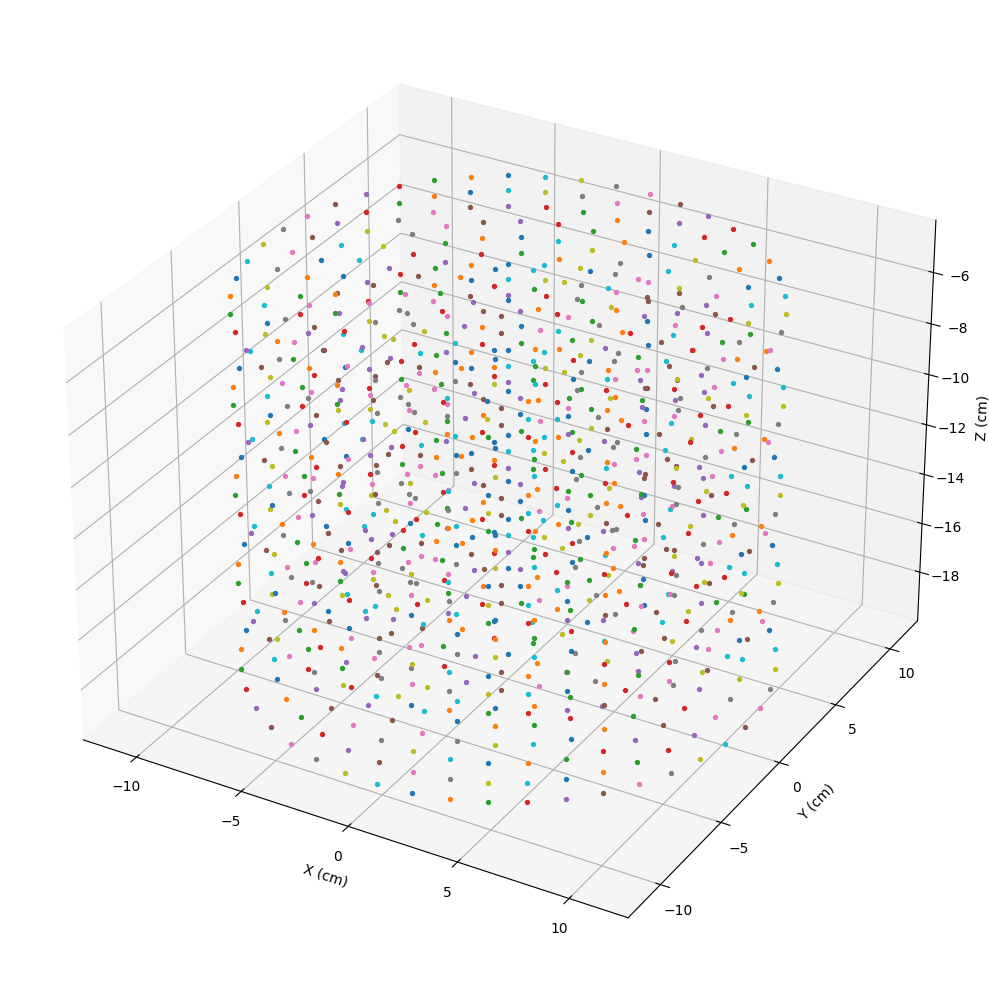

In [3]:
cparams = {
    'radius': 11.0,
    'height': 14.0,
    'rcount': 8,
    'mtcount': 45,
    'hcount':  5,
    'origin': [0.0, 0.0, -12.0],
}

# cparams = default_cylindrical_grid_params
grid = generate_cylindrical_grid(**cparams)
print(len(grid))
visualize_grid(grid)

11.0


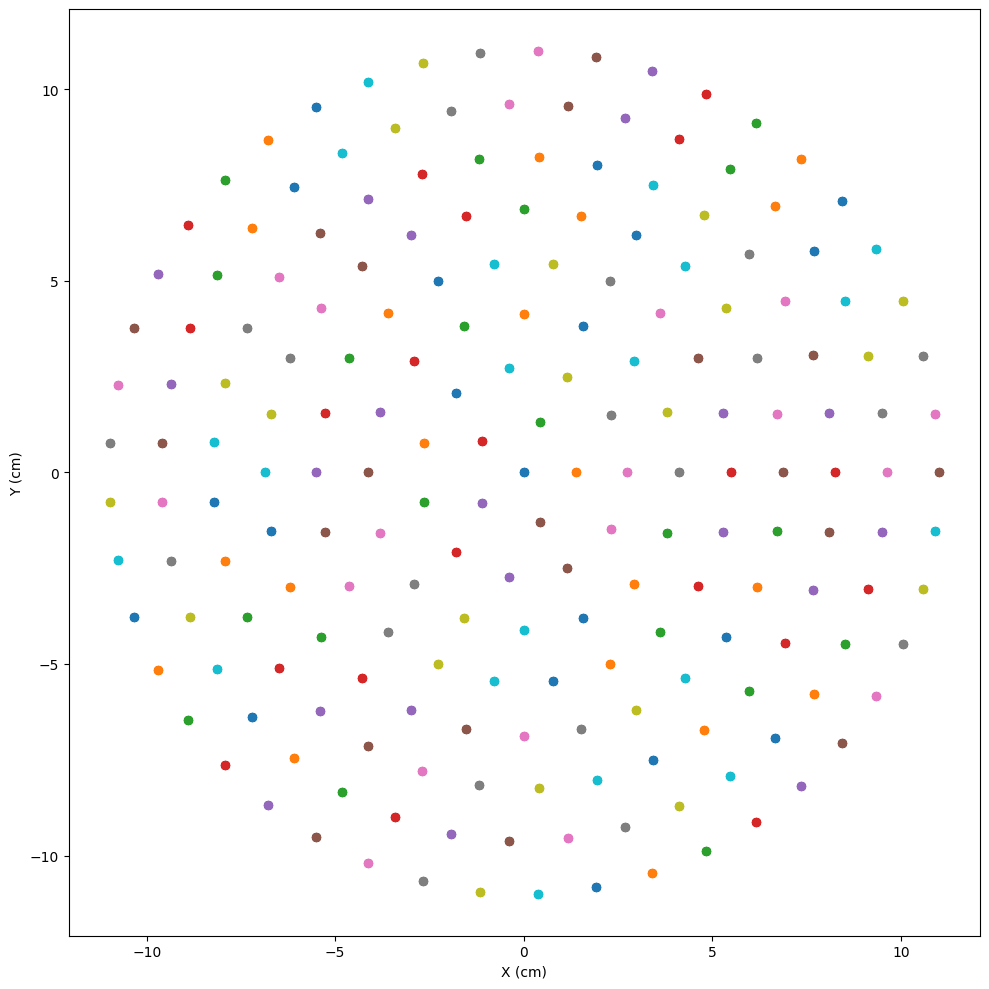

In [4]:
visualize_grid_2d(grid)
print(np.max(np.array(grid)[:,0]))

In [5]:
locs_dir = "outputs/grid_pixel_locations/predicted_proj_mats_w_ideal_jar_surface/"
# locs_dir = "outputs/grid_pixel_locations/predicted_proj_mats_w_distorted_jar_surface/"
# locs_dir = "outputs/grid_pixel_locations/actual_proj_mats_w_ideal_jar_surface/"
# locs_dir = "outputs/grid_pixel_locations/actual_proj_mats_w_distorted_jar_surface/"

loc_names = ['c1loc0', 'c1loc1', 'c1loc2', 'c2loc0', 'c2loc1', 'c2loc2', 'c3loc0', 'c3loc1', 'c3loc2'] 
cs = [c1, c1, c1, c2, c2, c2, c3, c3, c3]
comps = [components0, components1, components2, 
         components0, components1, components2, 
         components0, components1, components2]

locs = []
i = 0
for c in cs:
    try:
        # Try to load if the file already exists
        locs.append(np.load(locs_dir+loc_names[i]+".npy", allow_pickle=True))
    except OSError:
        # Otherwise, calculate and save
        loc = rendered_grid_projections(comps[i], c, grid, remapping_default_config)
        np.save(locs_dir+loc_names[i]+".npy", np.array(loc))
        locs.append(loc)
    i += 1

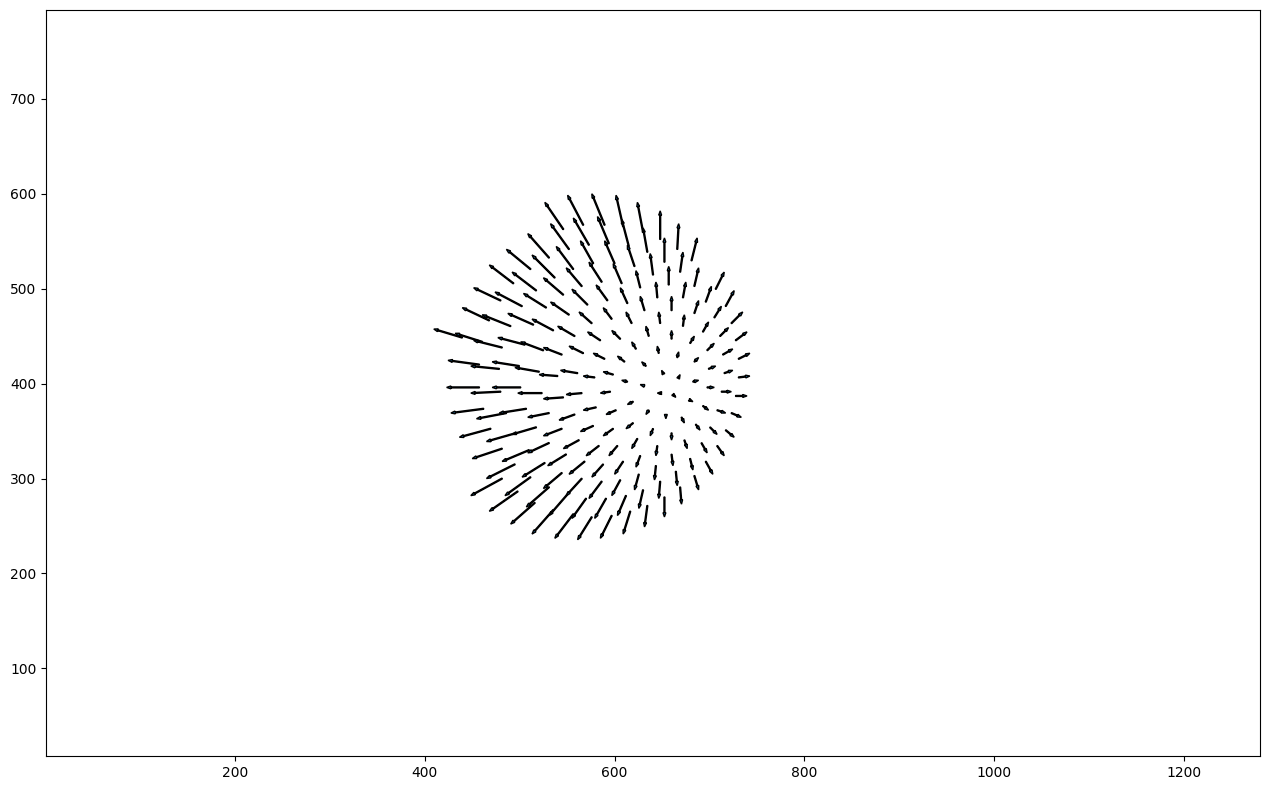

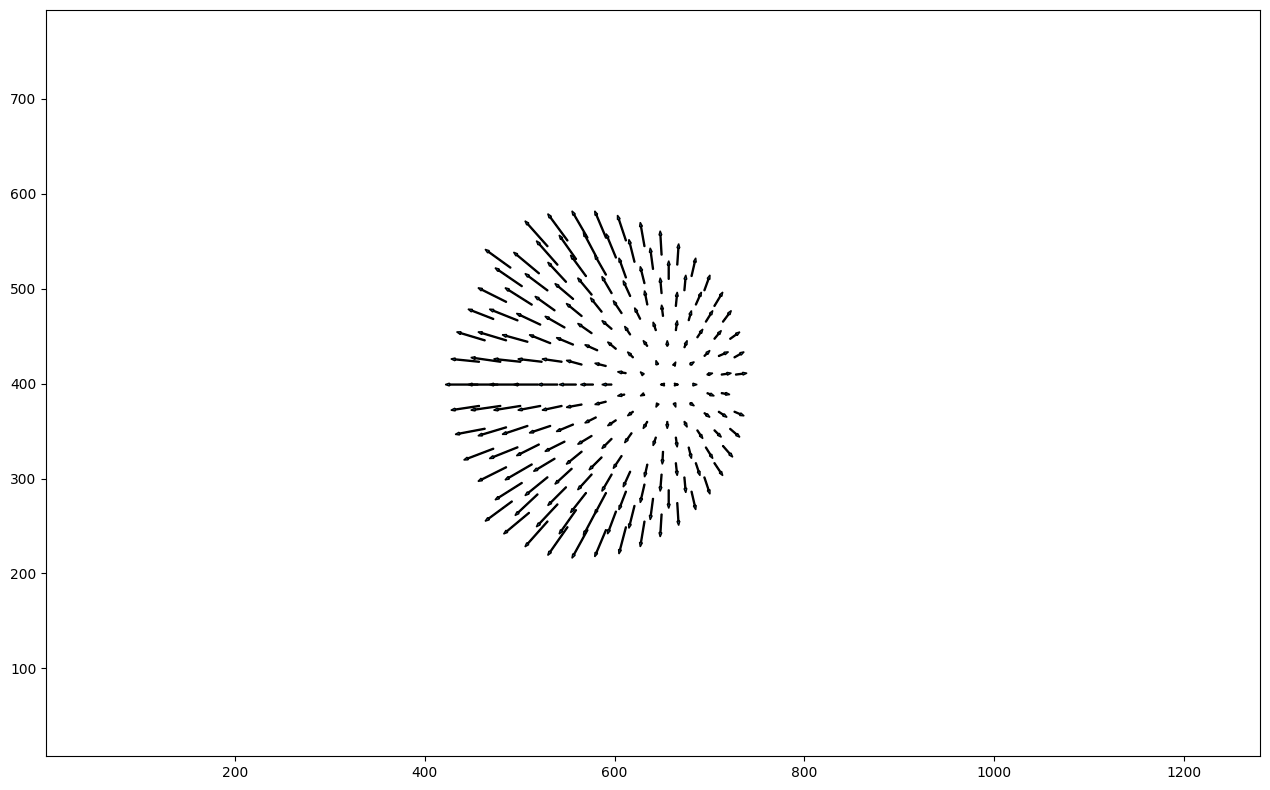

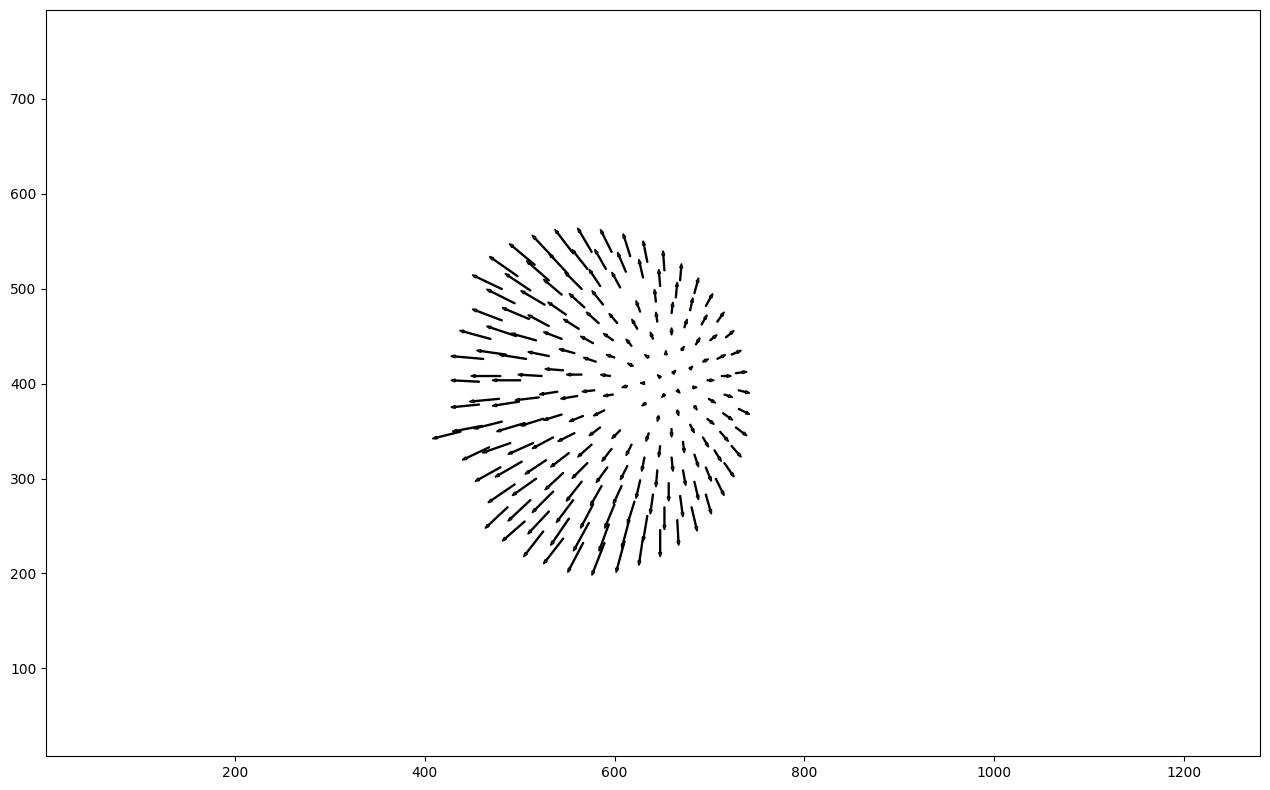

In [6]:
plot_remapping_arrows(locs[0][:200], locs[1][:200])
plot_remapping_arrows(locs[3][:200], locs[4][:200])
plot_remapping_arrows(locs[6][:200], locs[7][:200])

In [7]:
# project the points directly onto the image plane
actualp1 = []
actualp2 = []
actualp3 = []
inv_poses = compute_inverse_pose_matrices(poses)
for g in grid:
    actualp1.append(normalized_to_pixel(reproject(inv_poses[0], g)))
    actualp2.append(normalized_to_pixel(reproject(inv_poses[1], g)))
    actualp3.append(normalized_to_pixel(reproject(inv_poses[2], g)))
actualp1 = np.array(actualp1)
actualp2 = np.array(actualp2)
actualp3 = np.array(actualp3)

In [8]:
use_wrong_iors = False

lc1 = compute_linear_distortion_coeffs(actualp1, locs[1])
lc2 = compute_linear_distortion_coeffs(actualp2, locs[4])
lc3 = compute_linear_distortion_coeffs(actualp3, locs[7])

pc1 = compute_polynomial_distortion_coeffs(actualp1, locs[1])
pc2 = compute_polynomial_distortion_coeffs(actualp2, locs[4])
pc3 = compute_polynomial_distortion_coeffs(actualp3, locs[7])

pce1 = compute_polynomial_extended_distortion_coeffs(actualp1, locs[1])
pce2 = compute_polynomial_extended_distortion_coeffs(actualp2, locs[4])
pce3 = compute_polynomial_extended_distortion_coeffs(actualp3, locs[7])

if use_wrong_iors:
    lc1 = compute_linear_distortion_coeffs(actualp1, locs[2])
    lc2 = compute_linear_distortion_coeffs(actualp2, locs[5])
    lc3 = compute_linear_distortion_coeffs(actualp3, locs[8])

    pc1 = compute_polynomial_distortion_coeffs(actualp1, locs[2])
    pc2 = compute_polynomial_distortion_coeffs(actualp2, locs[5])
    pc3 = compute_polynomial_distortion_coeffs(actualp3, locs[8])

    pce1 = compute_polynomial_extended_distortion_coeffs(actualp1, locs[2])
    pce2 = compute_polynomial_extended_distortion_coeffs(actualp2, locs[5])
    pce3 = compute_polynomial_extended_distortion_coeffs(actualp3, locs[8])

print(lc1)
print(lc2)
print(lc3)

print(pc1)
print(pc2)
print(pc3)

print(pce1)
print(pce2)
print(pce3)

[[112.95532313]
 [  0.83530745]
 [ 68.03515638]
 [  0.83293833]]
[[103.08244113]
 [  0.84220915]
 [ 58.42953076]
 [  0.83986609]]
[[102.6570379 ]
 [  0.83954949]
 [ 70.20166504]
 [  0.83566647]]
[[ 1.27866077e+02]
 [ 7.44967300e-01]
 [ 1.37813398e-04]
 [-7.67022603e-11]
 [ 8.54000381e+01]
 [ 7.04499689e-01]
 [ 2.48203264e-04]
 [-2.31713222e-10]]
[[ 1.02479881e+02]
 [ 8.13605486e-01]
 [ 7.06897499e-05]
 [-5.49638306e-11]
 [ 7.16808775e+01]
 [ 7.32424266e-01]
 [ 2.25483189e-04]
 [-2.41303017e-10]]
[[ 1.07528296e+02]
 [ 7.87144366e-01]
 [ 9.96543617e-05]
 [-6.73975935e-11]
 [ 8.68828777e+01]
 [ 7.04378941e-01]
 [ 2.67466429e-04]
 [-2.71273873e-10]]
[[-3.32226466e+02]
 [ 3.41905686e+00]
 [-4.43145972e-03]
 [ 5.23279498e-09]
 [-4.64647460e-15]
 [ 1.71950815e-21]
 [ 9.25837585e+01]
 [ 6.22382416e-01]
 [ 5.11241022e-04]
 [-1.18752423e-09]
 [ 2.32815409e-15]
 [-2.21105650e-21]]
[[-5.18422115e+02]
 [ 4.39665392e+00]
 [-6.01285290e-03]
 [ 6.93997148e-09]
 [-6.07388879e-15]
 [ 2.23609540e-21]
 [ 

2.112490250976916


Text(0.5, 1.0, 'Ideal Jar Surface and Estimated Pose\n Fit Using Extended Polynomial Distortion Model\nAverage Remapping Error: 2.1125 pixels')

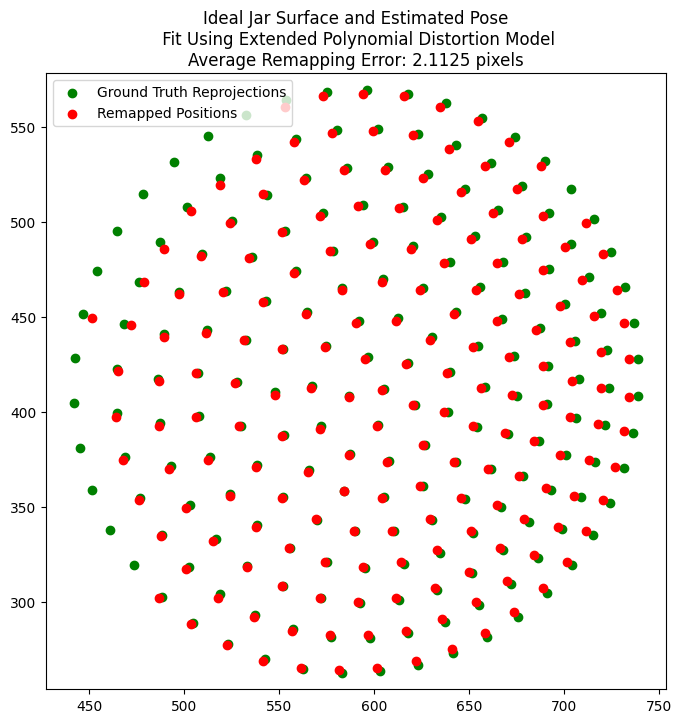

In [9]:
undistort_points = 5
actual_mode = 0
undistort_mode = ""

if undistort_points == 0: # compare to predicted position using OpenCV with no distortive elements
    undistort_mode = "Using OpenCV Estimated Pixel Positions With No Distortive Elements"
    up1 = locs[0]
    up2 = locs[3]
    up3 = locs[6]
elif undistort_points == 1: # compare to predicted position using OpenCV with distortive elements
    undistort_mode = "Using OpenCV Estimated Pixel Positions With Distortive Elements"
    up1 = locs[1]
    up2 = locs[4]
    up3 = locs[7]
elif undistort_points == 2: # compare to predicted position using OpenCV with distortive elements and wrong IoRs
    undistort_mode = "Using OpenCV Estimated Pixel Positions With Distortive Elements With Wrong IoRs"
    up1 = locs[2]
    up2 = locs[5]
    up3 = locs[8]
elif undistort_points == 3: # use the linear distortion coefficients to undistort the points computed by opencv
    undistort_mode = "Using Linear Distortion Model"
    up1 = linear_undistort(locs[1], lc1)
    up2 = linear_undistort(locs[4], lc2)
    up3 = linear_undistort(locs[7], lc3)
elif undistort_points == 4: # use the polynomial distortion coefficients to undistort the points computed by opencv
    undistort_mode = "Using Polynomial Distortion Model"
    up1 = polynomial_undistort(locs[1], pc1)
    up2 = polynomial_undistort(locs[4], pc2)
    up3 = polynomial_undistort(locs[7], pc3)
elif undistort_points == 5: # use the extended polynomial distortion coefficients to undistort the points computed by opencv
    undistort_mode = "Using Extended Polynomial Distortion Model"
    up1 = polynomial_extended_undistort(locs[1], pce1)
    up2 = polynomial_extended_undistort(locs[4], pce2)
    up3 = polynomial_extended_undistort(locs[7], pce3)


projected = np.array(up1)

actual_mode_d = ""
if actual_mode == 0: # Use exact reprojections
    actual = np.array(actualp1)
    actual_mode_d = "Ground Truth Reprojections"
elif actual_mode == 1: # Use OpenCV predicted positions without refractive elements
    actual = np.array(locs[0])
    actual_mode_d = "OpenCV Predicted Positions"
elif actual_mode == 2: # Use OpenCV predicted positions with refractive elements
    actual = np.array(locs[1])

remapping_errors = []
for i in range(actual.shape[0]):
    if np.all(projected[i]) and np.all(actual[i]):
        remapping_errors.append(np.linalg.norm(actual[i] - projected[i]))
avg_remapping_error = np.average(np.array(remapping_errors))
print(avg_remapping_error)

# jar_surface_mode = "Distorted Jar Surface and Estimated Pose"
jar_surface_mode = "Ideal Jar Surface and Estimated Pose"
# jar_surface_mode = "Ideal Jar Surface and Ground Truth Pose"
# jar_surface_mode = "Distorted Jar Surface and Ground Truth Pose"
# jar_surface_mode = "Ideal Jar Surface and Ground Truth Pose, IoRs off by -1%"
plt.figure(figsize=(8,8))
plt.scatter(actual[:200,0], actual[:200,1], c='g', label=actual_mode_d)
plt.scatter(projected[:200,0], projected[:200,1], c='r', label="Remapped Positions")
plt.axis('equal')
plt.legend()
plt.title(jar_surface_mode+"\n Fit "+undistort_mode+"\nAverage Remapping Error: " + "{:.4f}".format(avg_remapping_error)+" pixels")

In [15]:
use_actual_reprojections = False
random_pixel_offset = 0.0
opt_mode = 5
opt_name = ""

predictions = []
losseses = [] # great naming, I know :)
print("Number of points: ", up1.shape[0])
for i in range(up1.shape[0]):
    if use_actual_reprojections:
        clocs = np.stack([actualp1[i], actualp2[i], actualp3[i]])
    else:
        clocs = np.stack([up1[i], up2[i], up3[i]], axis=0)

    if np.all(clocs != None):

        clocs = np.array([normalize_coordinate(random_pixel_offset*random_in_unit_circle() + c) for c in clocs])

        if opt_mode == 1: # N-view
            predictions.append(n_view_triangulate(poses, clocs))
            opt_name = "N-view Triangulation"
        elif opt_mode == 2: # N-view basic gradient descent
            pred, _, losses = gradient_descent_optimization(poses, clocs, iterations=100, delta=0.0005, scale_delta=False)
            predictions.append(pred)
            losseses.append(losses)
            opt_name = "N-view Triangulation with Basic Gradient Descent"
        elif opt_mode == 3: # N-view basic gradient descent with delta scaling
            pred, _, losses = gradient_descent_optimization(poses, clocs, iterations=100, delta=0.001, scale_delta=True)
            predictions.append(pred)
            losseses.append(losses)
            opt_name = "N-view Triangulation with Basic Gradient Descent and Delta Scaling"
        elif opt_mode == 4: # N-view gradient descent
            pred, _, losses = gradient_descent_optimization(poses, clocs, iterations=100, delta=0.01, scale_delta=False, basic_mode=False)
            predictions.append(pred)
            losseses.append(losses)
            opt_name = "N-view Triangulation with Gradient Descent"
        elif opt_mode == 5: # N-view gradient descent with delta scaling
            pred, _, losses = gradient_descent_optimization(poses, clocs, iterations=100, delta=0.1, scale_delta=True, basic_mode=False)
            predictions.append(pred)
            losseses.append(losses)
            opt_name = "N-view Triangulation with Gradient Descent and Delta Scaling"
        elif opt_mode == 6: # N-view levenberg_marquardt
            pred, _, losses = levenberg_marquardt_optimization(poses, clocs, iterations=20, delta=0.0001, lmb=1.0, scale_lmb=2.0)
            predictions.append(pred)
            losseses.append(losses)
            opt_name = "N-view Triangulation with Levenberg-Marquardt"
        else: # average two-view
            opt_name = "Averge Mid-point Two View Triangulation"
            predictions.append(average_two_view_triangulate(poses, clocs))
    else:
        predictions.append(np.array([None, None, None]))
    print("Current Point: ", i, end='\r')

predictions = np.array(predictions)

errors = []
i = 0
for pred in predictions:
    if np.all(pred != None):
        err = np.linalg.norm(pred - grid[i])
        errors.append(err)
    else:
        errors.append(None)
    i += 1
errors = np.array(errors)

# print(errors)

Number of points:  1000


Max error (cm): 0.4804993609734602
Average error (cm):  0.14617501984126688


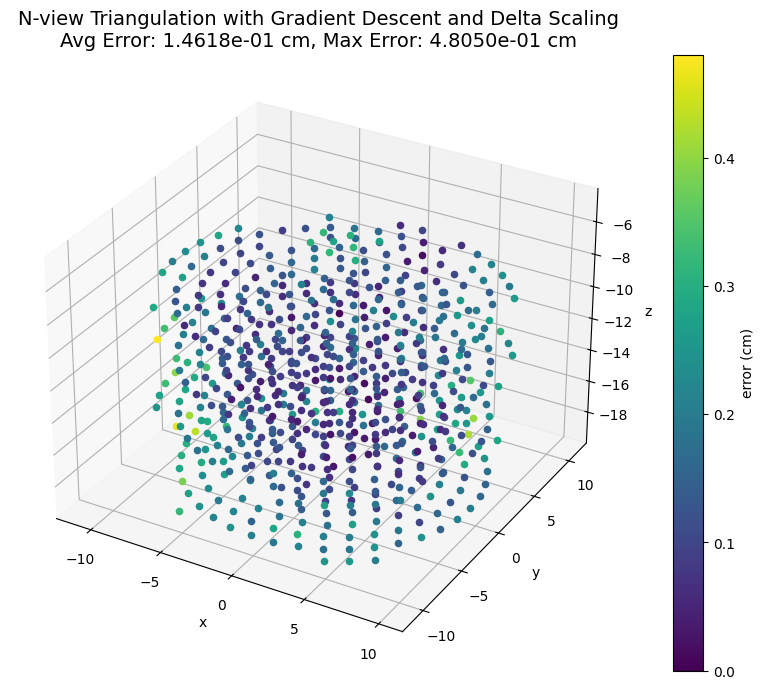

In [16]:
nerrors = np.array([e for e in errors if e != None])
vmax = np.max(nerrors)
print("Max error (cm):", vmax)
avgerr = np.average(nerrors)
print("Average error (cm): ", avgerr)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection='3d')
ax.set_title(opt_name+"\nAvg Error: "+"{:.4e}".format(avgerr)+" cm, Max Error: "+"{:.4e}".format(vmax)+" cm", fontsize=14)
# ax.set_title("IoRs off by -1%\nAvg Error: "+"{:.4e}".format(avgerr)+" cm, Max Error: "+"{:.4e}".format(vmax)+" cm", fontsize=14)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

i = 0
sc = None
for point in grid:
    if errors[i] != None:
        sc = ax.scatter(point[0], point[1], point[2], c=errors[i], cmap='viridis', vmin=0, vmax=vmax)
    i += 1
fig.colorbar(sc, label="error (cm)")

Text(0.5, 1.0, 'N-view Triangulation with Gradient Descent and Delta Scaling\nAverage Improvement in Reprojection Error: 0.6587%')

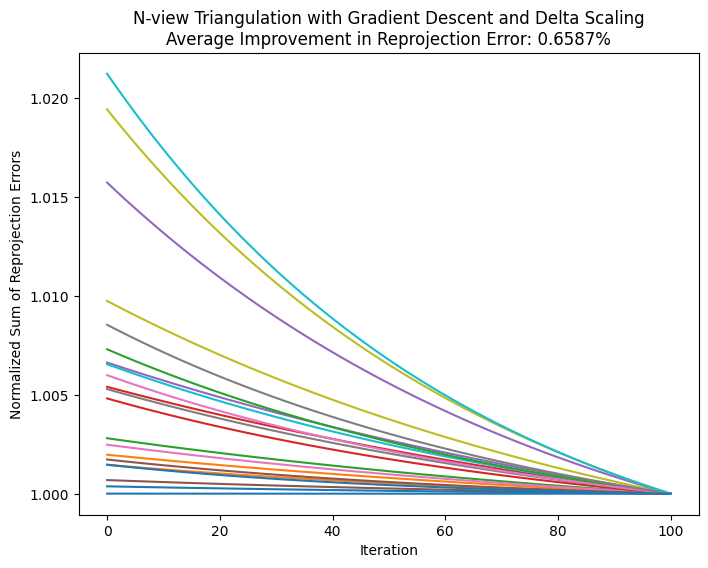

In [17]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()

i = 0
n = len(losseses)
m = 20
for ls in losseses:
    if i%(n//m) == 0: # Choose m of the loss curves
        # ax.plot(ls)
        ax.plot(ls/np.min(ls)) # normalize by minimum loss to check convergence
    i += 1
ax.set_xlabel("Iteration")
# ax.set_ylabel("Sum of Reprojection Errors")
ax.set_ylabel("Normalized Sum of Reprojection Errors")
avg_improvement = (np.average(np.array([ls[0]/ls[-1] for ls in losseses]))-1)*100
ax.set_title(opt_name+"\nAverage Improvement in Reprojection Error: "+"{:.4f}".format(avg_improvement)+"%")

0.14617501984126688
0.0808054133464347


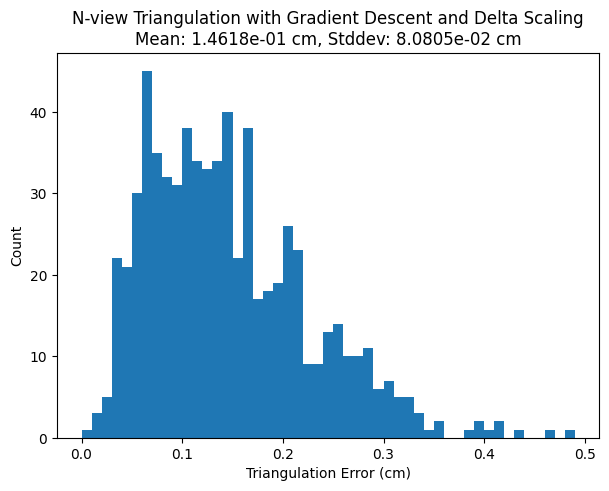

In [18]:
# Round max up to closest tenths place in error. 10 left-aligned bins per 0.1cm interval
bins = np.arange(int(np.max(nerrors)*10+1)*10)/100
plt.figure(figsize=(7,5))
plt.hist(nerrors, bins=bins)
plt.xlabel("Triangulation Error (cm)")
plt.ylabel("Count")
plt.title(opt_name+"\nMean: " + "{:.4e}".format(np.mean(nerrors)) + " cm, Stddev: " + "{:.4e}".format(np.std(nerrors)) + " cm")
print(np.mean(nerrors))
print(np.std(nerrors))

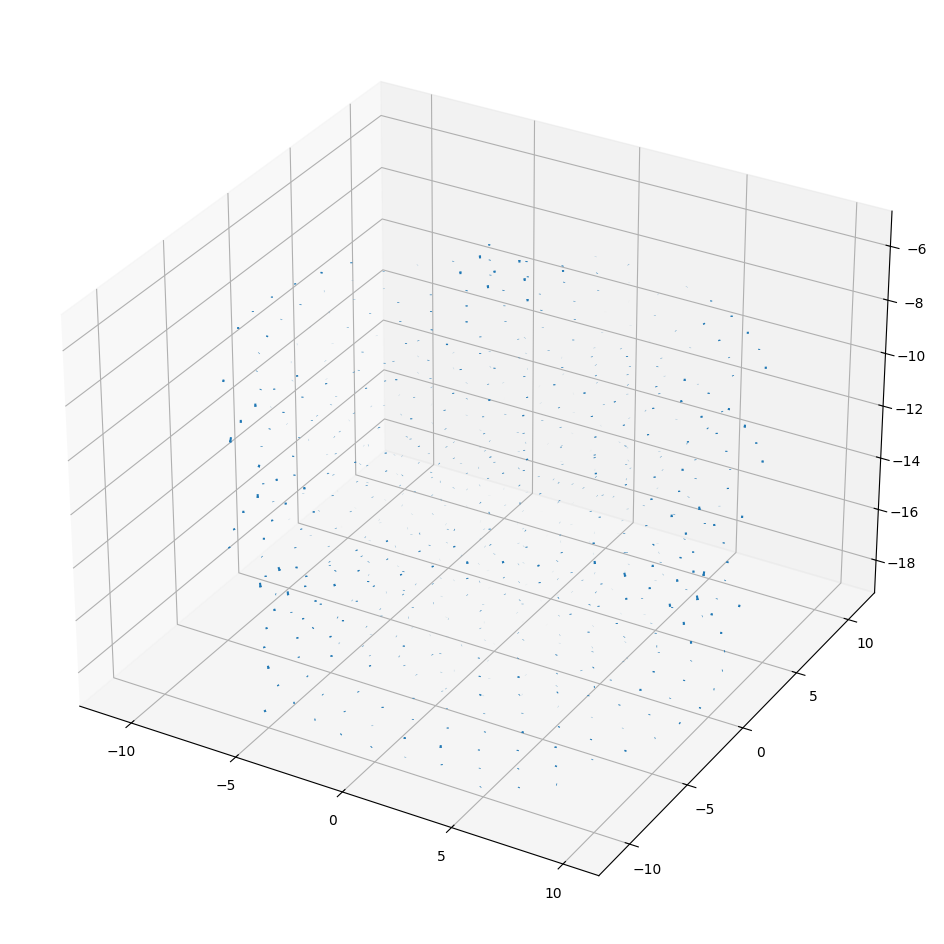

In [19]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')

i = 0
for pred in predictions:
    if np.all(pred != None):
        point = grid[i]
        dir = pred - point
        ldir = np.linalg.norm(dir) #* 10 # 10x length to make errors move visible
        ax.quiver(point[0], point[1], point[2], dir[0], dir[1], dir[2],
                  pivot='tail', length=ldir, arrow_length_ratio=0.3)
    i += 1
